In [1]:
# Network/data is small enough that running on GPU slows training down
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

https://baseballsavant.mlb.com/csv-docs

https://fivethirtyeight.com/features/mlbs-hit-tracking-tool-misses-a-lot-of-hits/

- Player ID map
https://www.smartfantasybaseball.com/tools/

- stats
http://www.seanlahman.com/baseball-archive/statistics/

# Load statcast data

In [2]:
import pandas as pd

try:
    df = pd.read_csv('./statcast-2019-04-10.csv')
except Exception:
    df = pd.read_csv('./statcast-2019-05-18.csv')
df.shape

/home/dante/venvs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(698334, 90)

In [3]:
df = df[df.game_year == 2018]
df.shape

(572572, 90)

In [4]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone
0,94.0,5.0,LAA,-11.3601,25.1390,-31.7129,1.0,2.0,5.0,543760.0,line_drive,NaN,NaN,Marcus Semien singles on a line drive to right...,hit_into_play_score,82.497,NaN,0.213,0.207,single,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,133.98,82.73,278.0,9.0,5.0,OAK,Strategic,11.0,Bot,0.0,25.0,82.1,3.0,Strategic,459964.0,NaN,621471.0,1.0,R,-0.9585,0.0858,Changeup,6.0,CH,598287.0,598287.0,1.0147,2.5574,Noe Ramirez,5.0,5.0,5.0,5.0,5.991,-2.6238,54.5068,5.0668,83.5,2202.0,NaN,NaN,R,2.0,180330_000927,1.3048,3.0286,NaN,NaN,X,NaN,10.1373,-121.0093,0.5756,1.0,0.9,12.0
1,94.0,5.0,LAA,-10.9769,23.0148,-32.6285,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,82.405,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,9.0,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,-17.0,75.1,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,-0.9663,0.0005,Changeup,5.0,CH,598287.0,598287.0,0.4161,2.7585,Noe Ramirez,5.0,5.0,5.0,5.0,6.174,-2.6167,54.3240,5.0671,82.7,2035.0,NaN,NaN,R,2.0,180330_000833,1.3010,3.0452,NaN,NaN,S,NaN,8.7471,-120.1073,1.2442,NaN,NaN,3.0
2,94.0,5.0,LAA,7.1848,23.4589,-32.9895,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,75.252,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,254.0,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,27.0,80.3,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,0.9971,-0.0254,Curveball,4.0,CU,598287.0,598287.0,-0.1869,2.1676,Noe Ramirez,5.0,5.0,5.0,5.0,5.360,-2.9329,55.1378,4.8254,77.2,2875.0,NaN,NaN,R,1.0,180330_000804,1.3010,3.0452,NaN,NaN,S,NaN,4.0109,-112.0582,1.4503,NaN,NaN,5.0
3,94.0,5.0,LAA,2.7950,23.1420,-33.8923,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,74.808,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,NaN,NaN,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,0.5234,-0.1545,Curveball,3.0,CU,598287.0,598287.0,0.7067,1.7718,Noe Ramirez,5.0,5.0,5.0,5.0,5.545,-2.8895,54.9534,4.8506,76.6,2722.0,NaN,NaN,R,0.0,180330_000729,1.3010,3.0452,NaN,NaN,S,NaN,6.5573,-111.0574,0.9231,NaN,NaN,9.0
4,94.0,5.0,LAA,6.9345,23.0959,-31.9858,NaN,1.0,5.0,543760.0,NaN,NaN,NaN,NaN,ball,76.087,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,NaN,NaN,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,1.0697,0.1136,Curveball,2.0,CU,598287.0,598287.0,2.3848,2.7632,Noe Ramirez,5.0,5.0,5.0,5.0,5.563,-2.8185,54.9349,4.8878,77.8,2880.0,NaN,NaN,R,0.0,180330_000704,1.6456,3.4918,NaN,NaN,B,NaN,9.0882,-112.7488,2.2400,NaN,NaN,12.0


In [5]:
with pd.option_context('display.max_columns', None):
    display(df[df.ax.isnull()].head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone
161,79.0,2.0,MIN,NaN,NaN,NaN,NaN,0.0,2.0,592696.0,NaN,NaN,NaN,NaN,missed_bunt,NaN,NaN,NaN,NaN,NaN,543376.0,543376.0,448801.0,570731.0,542921.0,592518.0,641820.0,430945.0,458675.0,2.0,2018-03-29,529414.0,R,2018.0,NaN,NaN,NaN,NaN,2.0,BAL,Infield shift,11.0,Top,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,0.0,L,NaN,NaN,NaN,2.0,NaN,542947.0,542947.0,NaN,NaN,Richard Bleier,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,1.0,180329_223046,1.3131,3.0208,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,73.0,5.0,LAA,NaN,NaN,NaN,NaN,1.0,5.0,446359.0,NaN,NaN,NaN,NaN,ball,NaN,NaN,NaN,NaN,NaN,518960.0,518960.0,621566.0,476704.0,656305.0,543760.0,459964.0,621471.0,572039.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Standard,9.0,Top,NaN,NaN,NaN,NaN,Standard,455117.0,NaN,NaN,2.0,R,NaN,NaN,NaN,2.0,NaN,595014.0,595014.0,NaN,NaN,Blake Treinen,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,0.0,180329_231427,1.6256,3.4754,NaN,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479,65.0,5.0,NYY,NaN,NaN,NaN,NaN,2.0,1.0,518626.0,NaN,NaN,NaN,NaN,swinging_strike,97.637,NaN,NaN,NaN,NaN,596142.0,596142.0,435522.0,642180.0,592273.0,544369.0,458731.0,543305.0,592450.0,5.0,2018-03-29,529415.0,R,2018.0,NaN,NaN,NaN,NaN,1.0,TOR,Infield shift,8.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,NaN,NaN,4-Seam Fastball,3.0,FF,476454.0,476454.0,NaN,NaN,Dellin Betances,5.0,1.0,5.0,1.0,6.467,NaN,NaN,NaN,97.2,2299.0,NaN,NaN,R,0.0,180329_225329,1.6244,3.5044,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678,67.0,1.0,MIL,NaN,NaN,NaN,0.0,1.0,0.0,452104.0,fly_ball,NaN,NaN,Chase Headley flies out to right fielder Domin...,hit_into_play,97.155,NaN,0.047,0.062,field_out,444489.0,444489.0,460075.0,519299.0,543768.0,606115.0,592885.0,456715.0,570267.0,1.0,2018-03-29,529413.0,R,2018.0,186.43,77.92,325.0,9.0,0.0,SD,Standard,9.0,Bot,0.0,31.0,86.5,3.0,Standard,641319.0,NaN,NaN,1.0,R,NaN,NaN,4-Seam Fastball,2.0,FF,608349.0,608349.0,NaN,NaN,Corey Knebel,1.0,0.0,1.0,0.0,6.438,NaN,NaN,NaN,97.4,2584.0,NaN,NaN,L,0.0,180329_224527,1.3430,3.1214,NaN,NaN,X,NaN,NaN,NaN,NaN,1.0,0.0,NaN
1310,54.0,3.0,HOU,NaN,NaN,NaN,NaN,0.0,0.0,596059.0,NaN,NaN,NaN,NaN,foul,93.457,NaN,NaN,NaN,NaN,435263.0,435263.0,503556.0,514888.0,608324.0,621043.0,502210.0,545350.0,543807.0,3.0,2018-03-29,529411.0,R,2018.0,NaN,NaN,214.0,NaN,0.0,TEX,Infield shift,7.0,Bot,NaN,NaN,NaN,NaN,Strategic,NaN,NaN,NaN,2.0,R,NaN,NaN,4-Seam Fastball,1.0,FF,606965.0,606965.0,NaN,NaN,Chris Devenski,3.0,0.0,3.0,0.0,5.208,NaN,NaN,NaN,95.5,2326.0,NaN,NaN,L,0.0,180329_215455,1.1655,2.9233,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# df = df[df.type.ne('B')]
df = df[~df.game_pk.isnull()]
df.shape

(572572, 90)

## Remove at-bats due to fielding influence

In [7]:
invalid_events = {
    'catcher_interf',
    'fielders_choice_out',
    'field_error',
    'fielders_choice',
    'batter_interference',
}
invalid_at_bats = df.loc[:, ['game_pk', 'at_bat_number', 'events']]
invalid_at_bats['remove'] = invalid_at_bats.events.isin(invalid_events)
invalid_at_bats = invalid_at_bats.groupby(['game_pk', 'at_bat_number']).remove.max()

In [8]:
invalid_at_bats.sum()

1628

In [9]:
invalid_at_bats = pd.DataFrame(invalid_at_bats[~invalid_at_bats])
df = df.merge(invalid_at_bats, left_on=invalid_at_bats.index.names, right_index=True)
df.shape

(566962, 91)

# Load player IDs

In [10]:
player_ids = pd.read_excel('~/Downloads/SFBB-Player-ID-Map.xlsx')
player_ids.shape

(2177, 42)

In [11]:
with pd.option_context('display.max_columns', None):
    display(player_ids.head())

,IDPLAYER,PLAYERNAME,BIRTHDATE,FIRSTNAME,LASTNAME,TEAM,LG,POS,IDFANGRAPHS,FANGRAPHSNAME,MLBID,MLBNAME,CBSID,CBSNAME,RETROID,BREFID,NFBCID,NFBCNAME,ESPNID,ESPNNAME,KFFLNAME,DAVENPORTID,BPID,YAHOOID,YAHOONAME,MSTRBLLNAME,BATS,THROWS,FANTPROSNAME,LASTCOMMAFIRST,ROTOWIREID,FANDUELNAME,FANDUELID,DRAFTKINGSNAME,OTTONEUID,HQID,RAZZBALLNAME,FANTRAXID,FANTRAXNAME,ROTOWIRENAME,ALLPOS,NFBCLASTFIRST
0,aardsda01,David Aardsma,1981-12-27,David,Aardsma,NaN,NaN,P,1902,David Aardsma,430911.0,David Aardsma,479025.0,David Aardsma,aardd001,aardsda01,7307.0,David Aardsma,5933.0,David Aardsma,NaN,AARDSMA19811227A,45369.0,7307.0,David Aardsma,"Aardsma, David",R,R,David Aardsma,"Aardsma, David",7633.0,NaN,NaN,David Aardsma,4362.0,NaN,David Aardsma,NaN,NaN,David Aardsma,P,"Aardsma, David"
1,abadfe01,Fernando Abad,1985-12-17,Fernando,Abad,NaN,NaN,P,4994,Fernando Abad,472551.0,Fernando Abad,1723564.0,Fernando Abad,abadf001,abadfe01,8767.0,Fernando Abad,30417.0,Fernando Abad,NaN,ABAD19851217A,49706.0,8767.0,Fernando Abad,"Abad, Fernando",L,L,Fernando Abad,"Abad, Fernando",11285.0,Fernando Abad,12453.0,Fernando Abad,7372.0,3556.0,Fernando Abad,01viz,"Abad, Fernando",Fernando Abad,P,"Abad, Fernando"
2,abreual01,Albert Abreu,1995-09-26,Albert,Abreu,NYY,AL,P,sa828366,Albert Abreu,656061.0,Albert Abreu,2211792.0,Albert Abreu,NaN,abreual01,10546.0,Albert Abreu,36041.0,NaN,NaN,NaN,104651.0,NaN,NaN,"Abreu, Albert",R,R,Albert Abreu,"Abreu, Albert",14063.0,NaN,NaN,NaN,NaN,5762.0,Albert Abreu,NaN,NaN,Albert Abreu,P,"Abreu, Albert"
3,abreubo01,Bobby Abreu,1974-03-11,Bobby,Abreu,NaN,NaN,OF,945,Bobby Abreu,110029.0,Bobby Abreu,7367.0,Bobby Abreu,abreb001,abreubo01,5698.0,Bobby Abreu,3537.0,Bobby Abreu,Bobby Abreu,ABREU19740311A,650.0,5698.0,Bobby Abreu,"Abreu, Bobby",L,R,Bobby Abreu,"Abreu, Bobby",NaN,NaN,NaN,NaN,8984.0,NaN,Bobby Abreu,NaN,NaN,NaN,OF,"Abreu, Bobby"
4,abreujo02,Jose Abreu,1987-01-29,Jose,Abreu,CHW,AL,1B,15676,Jose Abreu,547989.0,Jose Abreu,2106364.0,Jose Abreu,abrej003,abreujo02,9540.0,Jose Abreu,33095.0,Jose Abreu,Jose Abreu,ABREUcubaJ01,102005.0,9540.0,Jose Abreu,"Abreu, Jose",R,R,Jose Abreu,"Abreu, Jose",11341.0,Jose Abreu,49523.0,Jose Abreu,18286.0,4515.0,Jose Abreu,02i2e,"Abreu, Jose","Abreu, Jose",1B,"Abreu, Jose"


In [12]:
player_ids = player_ids[['MLBID', 'MLBNAME', 'IDPLAYER']]
batter_ids = player_ids.copy()
batter_ids.columns = [f'batter_{c.lower()}' for c in batter_ids.columns]
pitcher_ids = player_ids.copy()
pitcher_ids.columns = [f'pitcher_{c.lower()}' for c in pitcher_ids.columns]

In [13]:
batter_ids = batter_ids[~batter_ids.batter_mlbid.isnull()]
pitcher_ids = pitcher_ids[~pitcher_ids.pitcher_mlbid.isnull()]

In [14]:
assert len(batter_ids) == batter_ids.batter_mlbid.nunique(), f'{len(batter_ids)} != {batter_ids.batter_mlbid.nunique()}'

In [15]:
assert len(pitcher_ids) == pitcher_ids.pitcher_mlbid.nunique(), f'{len(pitcher_ids)} != {pitcher_ids.pitcher_mlbid.nunique()}'

## Blend IDs in with statcast data

In [16]:
df = df.merge(batter_ids, left_on='batter', right_on='batter_mlbid', how='left')
df = df.merge(pitcher_ids, left_on='pitcher', right_on='pitcher_mlbid', how='left')
df.shape

(566962, 97)

In [17]:
with pd.option_context('display.max_columns', None):
    display(df[df.batter_mlbname.isnull()].sample(20).head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone,remove,batter_mlbid,batter_mlbname,batter_idplayer,pitcher_mlbid,pitcher_mlbname,pitcher_idplayer
58717,76.0,8.0,ATL,-3.0920,22.2088,-35.8959,NaN,1.0,1.0,592680.0,NaN,NaN,NaN,NaN,foul,80.275,NaN,NaN,NaN,NaN,435559.0,435559.0,518692.0,645277.0,475247.0,622666.0,660670.0,542255.0,455976.0,8.0,2018-05-10,529962.0,R,2018.0,NaN,NaN,NaN,NaN,1.0,MIA,Standard,8.0,Bot,NaN,NaN,NaN,NaN,Standard,605119.0,571506.0,NaN,2.0,L,-0.3731,-0.4065,Slider,4.0,SL,627894.0,627894.0,0.3811,2.6653,Luiz Gohara,8.0,1.0,8.0,1.0,5.458,1.4610,55.0424,6.5369,81.4,2533.0,NaN,NaN,R,2.0,180511_015645,1.6258,3.3572,NaN,NaN,S,NaN,-1.7050,-118.4825,-1.3400,NaN,NaN,6.0,False,NaN,NaN,NaN,627894.0,Luiz Gohara,goharlu01
312325,14.0,2.0,CHC,8.5267,23.9658,-26.2678,1.0,1.0,2.0,623520.0,ground_ball,NaN,NaN,David Bote singles on a sharp ground ball to c...,hit_into_play_no_out,83.609,NaN,0.56,0.511,single,518735.0,518735.0,571970.0,523253.0,457759.0,571771.0,592626.0,641355.0,624577.0,3.0,2018-06-27,530600.0,R,2018.0,123.37,82.63,64.0,8.0,3.0,LAD,Standard,2.0,Top,0.0,2.0,106.7,4.0,Standard,NaN,NaN,NaN,1.0,L,0.7537,0.5389,Changeup,5.0,CH,622072.0,622072.0,0.3668,1.5428,Alex Wood,2.0,2.0,3.0,3.0,5.934,2.0741,54.5647,5.6095,84.2,1464.0,NaN,NaN,R,2.0,180628_024138,1.4052,3.6364,NaN,NaN,X,NaN,-5.3921,-122.4052,-4.0757,1.0,0.9,9.0,False,NaN,NaN,NaN,622072.0,Alex Wood,woodal02
537235,32.0,2.0,BAL,17.5405,24.1879,-32.9334,NaN,0.0,2.0,592859.0,NaN,NaN,NaN,NaN,foul,85.591,NaN,NaN,NaN,NaN,543877.0,543877.0,456665.0,408252.0,571788.0,624407.0,607752.0,598265.0,596119.0,1.0,2018-09-26,531771.0,R,2018.0,NaN,NaN,NaN,NaN,1.0,BOS,Standard,4.0,Top,NaN,NaN,NaN,NaN,Standard,572073.0,430945.0,NaN,2.0,L,1.4933,-0.0963,Changeup,2.0,CH,519242.0,519242.0,0.2596,1.1362,Chris Sale,2.0,2.0,1.0,1.0,5.779,3.4830,54.7217,4.8667,86.5,2033.0,NaN,NaN,R,1.0,180927_003146,1.4655,3.1713,NaN,NaN,S,NaN,-10.5240,-125.4635,-2.4545,NaN,NaN,14.0,False,NaN,NaN,NaN,519242.0,Chris Sale,salech01
454053,51.0,1.0,CLE,3.0330,23.4576,-35.9234,0.0,2.0,3.0,623205.0,NaN,NaN,NaN,Andrew Velazquez called out on strikes.,called_strike,82.836,NaN,NaN,NaN,strikeout,547379.0,547379.0,650490.0,608070.0,570481.0,596019.0,446386.0,434658.0,466320.0,1.0,2018-09-12,531585.0,R,2018.0,NaN,NaN,NaN,2.0,3.0,TB,Standard,7.0,Bot,0.0,NaN,NaN,NaN,Standard,NaN,NaN,NaN,0.0,R,0.3446,-0.3519,Slider,5.0,SL,471911.0,471911.0,-0.5420,2.6191,Carlos Carrasco,1.0,3.0,1.0,3.0,6.026,-1.5546,54.4722,5.5105,83.2,2625.0,NaN,NaN,L,2.0,180912_190618,1.5054,3.2883,NaN,NaN,S,NaN,1.6471,-121.0736,0.4964,1.0,0.0,4.0,False,NaN,NaN,NaN,471911.0,Carlos Carrasco,carraca01
47742,79.0,7.0,BOS,-16.2059,32.8663,-24.1039,NaN,0.0,2.0,595453.0,NaN,NaN,NaN,NaN,foul,93.933,NaN,NaN,NaN,NaN,543877.0,543877.0,434670.0,456488.0,646240.0,593428.0,643217.0,598265.0,605141.0,7.0,2018-04-02,529458.0,R,2018.0,NaN,NaN,8.0,NaN,2.0,MIA,Standard,9.0,Bot,NaN,-13.0,86.8,NaN,Standard,621446.0,542513.0,NaN,0.0,R,-1.2319,0.5772,Sinker,1.0,SI,519393.0,519393.0,-0.7372,2.0295,Marcus Walden,7.0,2.0,7.0,2.0,6.954,-0.9397

# Load statistics

## Batting

In [18]:
batting_stats = pd.read_csv('baseballdatabank-2019.2/core/Batting.csv')
batting_stats = batting_stats.merge(batter_ids, left_on='playerID', right_on='batter_idplayer')
batting_stats = batting_stats[batting_stats.yearID == 2018]
batting_stats.shape

(1205, 25)

In [19]:
# players are represented multiple times when there is a trade
batting_stats = batting_stats.groupby('batter_mlbid', as_index=False)[[
    'H', 'BB', 'HBP', '2B', '3B', 'HR', 'SF', 'AB'
]].sum()
batting_stats['1B'] = batting_stats.H - (batting_stats['2B'] - batting_stats['3B'] - batting_stats['HR'])
batting_stats.shape

(1071, 10)

In [20]:
stats = batting_stats  # alias
stats['obp'] = (stats['H'] + stats['BB'] + stats['HBP']) / (stats['AB'] + stats['BB'] + stats['SF'] + stats['HBP'])
stats['slg'] = (stats['1B'] + (2*stats['2B']) + (3*stats['3B']) + (4*stats['HR'])) / stats.AB
stats['ops'] = stats.obp + stats.slg
stats['obp'].describe(), stats.slg.describe(), stats.ops.describe()

(count    823.000000
 mean       0.244371
 std        0.144940
 min        0.000000
 25%        0.161528
 50%        0.285714
 75%        0.330852
 max        1.000000
 Name: obp, dtype: float64, count    823.000000
 mean       0.345414
 std        0.246788
 min        0.000000
 25%        0.125000
 50%        0.388889
 75%        0.504371
 max        2.000000
 Name: slg, dtype: float64, count    823.000000
 mean       0.589784
 std        0.373841
 min        0.000000
 25%        0.312091
 50%        0.684118
 75%        0.835459
 max        3.000000
 Name: ops, dtype: float64)

## Pitching

In [21]:
pitching_stats = pd.read_csv('baseballdatabank-2019.2/core/Pitching.csv')
pitching_stats = pitching_stats[pitching_stats.yearID == 2018]
pitching_stats = pitching_stats.merge(pitcher_ids, left_on='playerID', right_on='pitcher_idplayer')
pitching_stats.shape

(657, 33)

In [22]:
pitching_stats['IP'] = pitching_stats.IPouts / 3

In [23]:
pitching_stats = pitching_stats.groupby([
    'pitcher_mlbid',
], as_index=False)[['IP', 'BB', 'H', 'ER']].sum()
pitching_stats.shape

(581, 5)

In [24]:
pitching_stats['ERA'] = ((pitching_stats.ER / pitching_stats.IP) * 9 )
pitching_stats['WHIP'] = (pitching_stats.BB + pitching_stats.H) / pitching_stats.IP

# Feature engineering

## Create target variable

Did the at-bat result in a hit or walk?

In [25]:
df.events.unique()

array(['single', nan, 'triple', 'strikeout', 'field_out', 'double',
       'walk', 'grounded_into_double_play', 'home_run', 'hit_by_pitch',
       'sac_bunt', 'pickoff_caught_stealing_2b', 'caught_stealing_2b',
       'force_out', 'double_play', 'sac_fly', 'other_out', 'pickoff_1b',
       'strikeout_double_play', 'caught_stealing_3b', 'pickoff_2b',
       'triple_play', 'sac_bunt_double_play', 'caught_stealing_home',
       'sac_fly_double_play', 'pickoff_3b',
       'pickoff_caught_stealing_home', 'pickoff_caught_stealing_3b',
       'run'], dtype=object)

In [26]:
import numpy as np
target_events = [
    'single',
    'double',
    'triple',
    'home_run',
    'walk',
]
target_events = {event: i for i, event in enumerate(target_events, start=1)}
df['target'] = df.events.map(target_events).fillna(0).astype(int)

## Create auxillary targets

In [27]:
auxillary_targets = [
    'hit_distance_sc',
    'launch_speed',
    'launch_angle',
]
for t in auxillary_targets:
    df[t] = (df[t] - df[t].mean()) / df[t].std()
df['auxillary_targets'] = df[auxillary_targets].fillna(0).values.tolist()

In [28]:
import numpy as np
np.stack(df.iloc[:10]['auxillary_targets'])

array([[ 0.94858298, -0.0637947 ,  0.29688873],
       [-1.26468766, -0.53543634, -1.15239467],
       [ 0.75111645, -0.18507398,  0.36590222],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 1.55743809,  0.5762904 ,  0.19336848],
       [ 0.42200558, -0.62302694,  1.26307766],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

# Who's on first

Or rather, is anyone on first.

In [29]:
df['runner_on_first'] = (~df.on_1b.isnull()).astype(int)
df['runner_on_second'] = (~df.on_2b.isnull()).astype(int)
df['runner_on_third'] = (~df.on_3b.isnull()).astype(int)

In [30]:
total_pitches = df.loc[:, ['game_pk', 'at_bat_number', 'pitch_number', 'pitcher']]
total_pitches['counter'] = 1

# How many pitches has the pitcher thrown

In [31]:
total_pitches.sort_values(['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'], inplace=True)
total_pitches['total_pitch_number'] = total_pitches.groupby([
    'game_pk', 'pitcher'
], as_index=False).counter.cumsum()
with pd.option_context('display.max_rows', None):
    display(total_pitches.head(100))

,game_pk,at_bat_number,pitch_number,pitcher,counter,total_pitch_number
3965,529406.0,1.0,1.0,502042.0,1,1
3944,529406.0,2.0,1.0,502042.0,1,2
3943,529406.0,2.0,2.0,502042.0,1,3
3942,529406.0,2.0,3.0,502042.0,1,4
3843,529406.0,3.0,1.0,502042.0,1,5
3842,529406.0,3.0,2.0,502042.0,1,6
3841,529406.0,3.0,3.0,502042.0,1,7
3840,529406.0,3.0,4.0,502042.0,1,8
3839,529406.0,3.0,5.0,502042.0,1,9
3838,529406.0,3.0,6.0,502042.0,1,10


In [32]:
df = df.merge(total_pitches, on=['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'])

# Create batter IDs to be embedded

In [33]:
import numpy as np
eligible_batters = batting_stats[batting_stats.AB > 100].batter_mlbid
df['batter_id'] = np.where(df.batter.isin(eligible_batters), df.batter, 0)

In [34]:
df[['batter_id', 'batter_mlbname']].drop_duplicates().shape

(820, 2)

## Create pitcher IDs to be embedded

In [35]:
eligible_pitchers = pitching_stats[pitching_stats.IP > 20].pitcher_mlbid
df['pitcher_id'] = np.where(df.pitcher.isin(eligible_pitchers), df.pitcher, 0)
len(eligible_pitchers), df.pitcher_id.nunique()

(451, 452)

# Define features

In [36]:
numeric_features = [
    'bat_score',  # these are pre-pitch
    'fld_score',  # these are pre-pitch
    'balls',
    'strikes',
    'outs_when_up',
    'pitch_number',
    'inning',
    'total_pitch_number',
    'at_bat_number',
    'ax',
    'ay',
    'az',
    'pfx_x',
    'pfx_z',
    'vx0',
    'vy0',
    'vz0',
    'release_speed',
    'release_spin_rate',
    'release_pos_x',
    'release_pos_y',
    'plate_x',
    'plate_z',
    'sz_top',
    'sz_bot',
]

categorical_features = [
    'if_fielding_alignment',
    'of_fielding_alignment',
    'inning_topbot',  # home field advantage
    'pitch_name',
    'zone',
    'pitcher_id',
    'batter_id',  # mapping of batters with less than 100 AB to 0
    'game_type',
    'stand',  # for batter
    'runner_on_first',
    'runner_on_second',
    'runner_on_third',
    'away_team',
    'home_team',
    'p_throws',
]

target = 'target'

# Linear model

## Define utilities

In [37]:
import sklearn

class GetDummies(sklearn.base.TransformerMixin):
    """Fast one-hot-encoder that makes use of pandas.get_dummies() safely
    on train/test splits.
    """
    def __init__(self, dtypes=None):
        self.input_columns = None
        self.final_columns = None
        if dtypes is None:
            dtypes = [object, 'category']
        self.dtypes = dtypes

    def fit(self, X, y=None):
        self.input_columns = list(X.select_dtypes(self.dtypes).columns)
        X = pd.get_dummies(X, columns=self.input_columns)
        self.final_columns = X.columns
        return self
        
    def transform(self, X, y=None):
        X = pd.get_dummies(X, columns=self.input_columns)
        X_columns = X.columns
        # if columns in X had values not in the data set used during
        # fit add them and set to 0
        missing = [c for c in self.final_columns if not c in X_columns]
        for c in missing:
            X[c] = 0
        # remove any new columns that may have resulted from values in
        # X that were not in the data set when fit
        return X[self.final_columns]
    
    def get_feature_names(self):
        return tuple(self.final_columns)


In [38]:
import tensorflow as tf
from keras.backend.tensorflow_backend import _to_tensor, epsilon

# basically copied from here
# https://github.com/keras-team/keras/blob/master/keras/backend/tensorflow_backend.py
def make_weighted_loss(weights):
    def weighted_categorical_crossentropy(target, output, from_logits=False, axis=-1):
        output_dimensions = list(range(len(output.get_shape())))
        if axis != -1 and axis not in output_dimensions:
            raise ValueError(
                '{}{}{}'.format(
                    'Unexpected channels axis {}. '.format(axis),
                    'Expected to be -1 or one of the axes of `output`, ',
                    'which has {} dimensions.'.format(len(output.get_shape()))))

        # scale preds so that the class probas of each sample sum to 1
        output /= tf.reduce_sum(output, axis, True)
        # manual computation of crossentropy
        _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
        return - tf.reduce_sum(target * tf.log(output) * weights, axis)
    return weighted_categorical_crossentropy

Using TensorFlow backend.


## Create training data

In [39]:
final_pitch = (df
    .sort_values(['game_pk', 'at_bat_number', 'pitch_number'])
    .groupby(['game_pk', 'at_bat_number'])
    .tail(1)
)
X = final_pitch[numeric_features + categorical_features]

y = np.zeros((len(X), len(target_events) + 1))
y[np.arange(len(y)), final_pitch[target].values] = 1
assert y.sum() == len(y)

In [40]:
y.mean(axis=0)

array([0.69502186, 0.14313696, 0.04505014, 0.00472433, 0.03040126,
       0.08166545])

In [41]:
X.isnull().any(axis=1).mean()

0.022304371215360635

In [42]:
X, y = X[~X.isnull().any(axis=1)], y[~X.isnull().any(axis=1)]

In [43]:
get_dummies = GetDummies()
X_t = X.copy()
for f in categorical_features:
    X_t[f] = X_t[f].astype(str)
X_t = get_dummies.fit_transform(X_t)

In [44]:
X_t.shape

(141760, 1008)

In [45]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    np.unique(np.argmax(y, axis=1)),
    np.argmax(y, axis=1)
)
class_weights, y.mean(axis=0)

(array([ 0.24018651,  1.16164348,  3.6887848 , 35.31639263,  5.45272713,
         2.02873662]),
 array([0.69390519, 0.14347489, 0.045182  , 0.00471924, 0.03056574,
        0.08215293]))

In [46]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

loss = make_weighted_loss(class_weights)
linear_model = Sequential()
linear_model.add(Dropout(0.05))
linear_model.add(BatchNormalization())
linear_model.add(Dense(len(target_events) + 1, activation='softmax', name='y', input_dim=X_t.shape[-1]))
linear_model.compile(loss=loss, optimizer='adam')
linear_model.fit(X_t.values, y, epochs=5)

Epoch 1/5
141760/141760 [==============================] - 16s 109us/step - loss: 1.5443
Epoch 2/5
141760/141760 [==============================] - 15s 107us/step - loss: 1.4358
Epoch 3/5
141760/141760 [==============================] - 15s 104us/step - loss: 1.4300
Epoch 4/5
141760/141760 [==============================] - 15s 105us/step - loss: 1.4411
Epoch 5/5
141760/141760 [==============================] - 15s 105us/step - loss: 1.4401


In [47]:
model_features = get_dummies.get_feature_names()
coefficients = linear_model.get_layer('y').get_weights()[0]

In [48]:
sorted([(f, c) for f, c in zip(model_features, coefficients[:, 0])], reverse=True, key=lambda x: abs(x[-1]))

[('strikes', 0.3273014),
 ('batter_id_0.0', 0.31728595),
 ('pitcher_id_0.0', 0.22762123),
 ('balls', -0.21994711),
 ('pitcher_id_493603.0', 0.21756342),
 ('batter_id_641313.0', 0.21567588),
 ('batter_id_491696.0', 0.21557495),
 ('batter_id_445055.0', 0.21480711),
 ('batter_id_642423.0', 0.20488618),
 ('pitcher_id_623352.0', 0.2004238),
 ('pitcher_id_600917.0', 0.19604601),
 ('batter_id_621433.0', 0.19434275),
 ('pitcher_id_434378.0', 0.19417483),
 ('pitcher_id_608678.0', 0.19039725),
 ('batter_id_642162.0', 0.19022107),
 ('batter_id_572365.0', 0.18867606),
 ('batter_id_595885.0', 0.18745719),
 ('batter_id_600474.0', 0.18704359),
 ('pitcher_id_592866.0', 0.18692856),
 ('pitcher_id_670950.0', 0.18452209),
 ('pitcher_id_461872.0', 0.18240304),
 ('batter_id_459964.0', 0.18184282),
 ('pitcher_id_501817.0', 0.17987078),
 ('batter_id_594988.0', 0.17911464),
 ('batter_id_572204.0', 0.17908733),
 ('batter_id_444876.0', 0.17898057),
 ('batter_id_547170.0', 0.17562154),
 ('batter_id_547379.0', 0.

In [49]:
feature_coefs = {feature: coef for feature, coef in zip(model_features, coefficients[:, 0])}
pitcher_coefs = {float(f.split('_')[-1]): c for f, c in feature_coefs.items() if 'pitcher' in f}
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
s = pitching_stats.copy().merge(pitchers, left_on='pitcher_mlbid', right_on='pitcher_id')
s['coef'] = s.pitcher_mlbid.map(pitcher_coefs)
s[s.IP > 100].sort_values('coef', ascending=False).head(10)

,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,pitcher_id,player_name,coef
13,434378.0,214.000000,37,156,60,2.523364,0.901869,434378.0,Justin Verlander,0.194175
282,592866.0,170.666667,55,146,59,3.111328,1.177734,592866.0,Trevor Williams,0.186929
449,670950.0,126.333333,54,121,62,4.416887,1.385224,670950.0,Trevor Richards,0.184522
81,471911.0,192.000000,43,173,72,3.375000,1.125000,471911.0,Carlos Carrasco,0.173992
48,453286.0,220.666667,51,150,62,2.528701,0.910876,453286.0,Max Scherzer,0.171509
24,446372.0,215.000000,34,179,69,2.888372,0.990698,446372.0,Corey Kluber,0.168751
327,605400.0,212.333333,58,149,56,2.373626,0.974882,605400.0,Aaron Nola,0.166924
361,608566.0,196.000000,57,179,82,3.765306,1.204082,608566.0,German Marquez,0.166013
281,592826.0,146.666667,59,138,79,4.847727,1.343182,592826.0,Vince Velasquez,0.161547
202,543699.0,180.333333,50,181,87,4.341959,1.280961,543699.0,Tanner Roark,0.152620


In [50]:
feature_coefs = {feature: coef for feature, coef in zip(model_features, coefficients[:, 0])}
pitcher_coefs = {float(f.split('_')[-1]): c for f, c in feature_coefs.items() if 'pitcher' in f}
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
s = pitching_stats.copy().merge(pitchers, left_on='pitcher_mlbid', right_on='pitcher_id')
s['coef'] = s.pitcher_mlbid.map(pitcher_coefs)
s[s.IP < 100].sort_values('coef', ascending=False).head(10)

,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,pitcher_id,player_name,coef
104,493603.0,77.666667,36,41,21,2.433476,0.991416,493603.0,Adam Ottavino,0.217563
395,623352.0,81.333333,30,36,22,2.434426,0.811475,623352.0,Josh Hader,0.200424
307,600917.0,57.666667,25,24,10,1.560694,0.849711,600917.0,Jose Leclerc,0.196046
365,608678.0,24.000000,8,27,12,4.500000,1.458333,608678.0,Dominic Leone,0.190397
74,461872.0,26.333333,14,28,18,6.151899,1.594937,461872.0,Anthony Swarzak,0.182403
107,501817.0,26.333333,5,19,7,2.392405,0.911392,501817.0,Tony Barnette,0.179871
138,518489.0,33.666667,7,19,6,1.603960,0.772277,518489.0,Ryan Brasier,0.172692
113,502026.0,76.666667,27,49,11,1.291304,0.991304,502026.0,Jeremy Jeffress,0.164168
337,606167.0,22.333333,9,17,5,2.014925,1.164179,606167.0,Adalberto Mejia,0.162873
23,446099.0,54.666667,22,52,32,5.268293,1.353659,446099.0,John Axford,0.159027


In [51]:
feature_coefs = {feature: coef for feature, coef in zip(model_features, coefficients[:, 1:].sum(axis=1))}
batter_coefs = {float(f.split('_')[-1]): c for f, c in feature_coefs.items() if 'batter' in f}
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
s = batting_stats.copy().merge(batters, left_on='batter_mlbid', right_on='batter_id')
s['coef'] = s.batter_mlbid.map(batter_coefs)
s.sort_values('coef', ascending=False).head(10)

,batter_mlbid,H,BB,HBP,2B,3B,HR,SF,AB,1B,obp,slg,ops,batter_id,batter_mlbname,coef
215,571745.0,170,70,10.0,38,4,26,7.0,596,162,0.366032,0.593960,0.959992,571745.0,Mitch Haniger,0.165982
266,592885.0,187,68,7.0,34,7,36,2.0,574,196,0.402458,0.747387,1.149845,592885.0,Christian Yelich,0.092069
327,607043.0,114,80,22.0,28,8,17,0.0,433,111,0.403738,0.598152,1.001891,607043.0,Brandon Nimmo,0.014766
295,596115.0,174,47,7.0,42,6,37,4.0,598,175,0.347561,0.710702,1.058263,596115.0,Trevor Story,0.013235
155,541650.0,80,17,0.0,11,2,9,1.0,316,80,0.290419,0.455696,0.746115,541650.0,Hernan Perez,0.002959
394,643217.0,168,71,2.0,41,6,16,7.0,579,149,0.365706,0.540587,0.906293,643217.0,Andrew Benintendi,-0.012259
162,543063.0,135,50,8.0,28,2,14,5.0,531,123,0.324916,0.453861,0.778776,543063.0,Brandon Crawford,-0.032561
135,518692.0,191,76,7.0,44,4,23,6.0,618,174,0.387553,0.592233,0.979786,518692.0,Freddie Freeman,-0.040859
367,624428.0,88,29,3.0,23,2,10,1.0,318,77,0.341880,0.531447,0.873327,624428.0,Adam Frazier,-0.045022
312,605141.0,180,81,8.0,47,5,32,5.0,520,170,0.438111,0.782692,1.220803,605141.0,Mookie Betts,-0.049660


# Getting deeper

## Define an encoder

To map IDs to valid range for `keras` embedding layers

In [52]:
from sklearn.base import TransformerMixin

class Encoder(TransformerMixin):
    def __init__(self):
        self.mappings = {}

    def fit(self, X):
        self.mappings = {
            feature: {v: i for i, v in enumerate(X[feature].unique())}
            for feature in X.columns
        }
        return self
    
    def transform(self, X):
        return {
            f'{feature}_input': X[feature].map(self.mappings[feature]).values
            for feature in X.columns
            if feature in self.mappings
        }

    def inverse_transform(self, X, feature):
        return X.map({v: k for k, v in self.mappings[feature].items()})
    
    def get_feature_dim(self, feature):
        return len(self.mappings[feature])

## Build batches for training

In [53]:
encoder = Encoder()
encoder.fit(df[categorical_features])

In [54]:
if False:
    sample_key = df[['game_pk', 'at_bat_number']].apply(lambda x: hash(tuple(x)) % 100, axis=1)
    df_sample = df[sample_key <= 10]
else:
    df_sample = df

In [55]:
df_sample.shape

(566962, 106)

Here we "featurize" each at-bat. In the following step we sort each at-bat by the number of pitches thrown and build the batches based on these groups so that we minimize padding during training.

In [56]:
from tqdm import tqdm_notebook as tqdm

df_sample.sort_values(['game_pk', 'at_bat_number', 'pitch_number'], inplace=True)

groups = df_sample.groupby([
    'game_pk', 'at_bat_number'
], as_index=False)
groups = list(groups)
np.random.shuffle(groups)

X_train = []
y_train = []

def featurize_at_bat(group):
    (game_pk, at_bat_number), group_df = group
    x = encoder.transform(group_df[categorical_features])
    x['numeric_inputs'] = group_df[numeric_features].values
    
    y = np.zeros((len(target_events) + 1,))
    assert len(group_df.target.unique()) <= 2
    y[group_df.target.max()] = 1
    
    y_aux = np.stack(group_df['auxillary_targets'])
    return x, y, y_aux, len(x['numeric_inputs'])

In [57]:
import multiprocessing as mp
import numpy as np

# this takes ridiculously long if not parallelized
pool = mp.Pool(2 * mp.cpu_count())
res = pool.imap_unordered(featurize_at_bat, tqdm(groups))
res = sorted(res, key=lambda x: x[-1])
X_train, y_train, y_aux_train, batch_lens = zip(*res)

Process ForkPoolWorker-24:
Process ForkPoolWorker-14:
Process ForkPoolWorker-19:
Process ForkPoolWorker-22:
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-10:
Process ForkPoolWorker-16:
Process ForkPoolWorker-1:
Process ForkPoolWorker-23:
Process ForkPoolWorker-5:
Process ForkPoolWorker-21:
Traceback (most recent call last):
Process ForkPoolWorker-20:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multipro

  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-15:
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
Process ForkPoolWorker-8:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py"

In [58]:
len(X_train), len(y_train), len(y_aux_train)

(144994, 144994, 144994)

## Create a list of the batches

In [59]:
import numpy as np

# assign each at-bat an ID so that each batch
# has roughly 32 at-bats
batch_ids = np.cumsum(batch_lens) // (4 * 32)
len(batch_ids), len(set(batch_ids))

(144994, 4430)

In [60]:
batch_ids[:1000:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [61]:
from itertools import groupby
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train, y_aux_train), key=lambda x: next(i))

In [62]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

input_features = [
    f'{f}_input' for f in categorical_features
] + ['numeric_inputs']

def batch_generator(gb):
    for batch_id, batch in gb:
        xs, ys, ys_aux = zip(*list(batch))
        X_batch = {}
        for f in input_features:
            X_batch[f] = pad_sequences([x[f] for x in xs])
        y = np.array(ys)
        y_aux = np.array(ys_aux)
        yield X_batch, y, y_aux
        

In [63]:
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train, y_aux_train), key=lambda x: next(i))
batches = list(batch_generator(gb))

In [64]:
len(batches)

4430

In [65]:
batches[0][0]['numeric_inputs'].shape, batches[0][1].shape, batches[0][2].shape

((127, 1, 25), (127, 6), (127, 1, 3))

In [66]:
batches[-1][0]['numeric_inputs'].shape, batches[-1][1].shape, batches[-1][2].shape

((3, 21, 25), (3, 6), (3,))

In [67]:
i_range = iter(range(len(batches)))

In [68]:
i = next(i_range)
batches[i][0]['numeric_inputs'].shape, batches[i][1].shape, batches[i][2].shape

((127, 1, 25), (127, 6), (127, 1, 3))

# Hybrid model

In [69]:
import keras
import keras.backend as K

# LSTM input
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh', name='W')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear', name='u_w')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention


categorical_dimmensions = {
    'batter_id': 1,
    'pitcher_id': 1,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = {}
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings[feature] = embedding

# Average is just a hacky way to get these embeddings 2D.
Avg = keras.layers.Lambda(lambda x: K.mean(x, axis=1))
batter_embedding = Avg(embeddings.pop('batter_id'))
pitcher_embedding = Avg(embeddings.pop('pitcher_id'))
X_embeddings = keras.layers.Concatenate(axis=-1)(list(embeddings.values()))

X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.BatchNormalization()(X)
X_lstm = keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)(X)
X, attention = Attention(X_lstm)
X = keras.layers.Concatenate()([
    X,
    pitcher_embedding,
    batter_embedding
])
X = keras.layers.Dense(len(target_events) + 1, activation='softmax', name='y')(X)

hybrid_model = keras.models.Model(
    inputs=[numeric_input] + list(categorical_inputs),
    outputs=X)

In [70]:
hybrid_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [71]:
from sklearn.utils.class_weight import compute_class_weight
y = np.concatenate([y for _, y, _ in batches])
class_weights = compute_class_weight(
    'balanced',
    np.unique(np.argmax(y, axis=1)),
    np.argmax(y, axis=1)
)
class_weights

array([ 0.23980061,  1.16438598,  3.69958155, 35.2783455 ,  5.48222928,
        2.04084678])

In [72]:
hybrid_model.compile(loss=loss, optimizer='adam')

In [73]:
L = []
def g():
    while True:
        np.random.shuffle(batches)
        for X, y, y_aux in batches:
            if len(y_aux.shape) != 3:
                L.append(None)
                continue
            yield X, y
hybrid_model.fit_generator(g(), steps_per_epoch=len(batches), epochs=10)

Epoch 1/10
4430/4430 [==============================] - 40s 9ms/step - loss: 1.4457
Epoch 2/10
4430/4430 [==============================] - 38s 8ms/step - loss: 1.3192
Epoch 3/10
4430/4430 [==============================] - 37s 8ms/step - loss: 1.2727
Epoch 4/10
4430/4430 [==============================] - 38s 9ms/step - loss: 1.2344
Epoch 5/10
4430/4430 [==============================] - 38s 9ms/step - loss: 1.2130
Epoch 6/10
4430/4430 [==============================] - 38s 9ms/step - loss: 1.1870
Epoch 7/10
4430/4430 [==============================] - 38s 9ms/step - loss: 1.1753
Epoch 8/10
4430/4430 [==============================] - 38s 9ms/step - loss: 1.1601
Epoch 9/10
4430/4430 [==============================] - 38s 9ms/step - loss: 1.1455
Epoch 10/10
4430/4430 [==============================] - 38s 9ms/step - loss: 1.1469


In [74]:
len(L)

141

## P/R curves

In [75]:
preds = np.concatenate([hybrid_model.predict(x) for x, _, _ in batches])
y_all = np.concatenate([y for _, y, _ in batches])

In [76]:
y_all.mean(axis=0)

array([0.69502186, 0.14313696, 0.04505014, 0.00472433, 0.03040126,
       0.08166545])

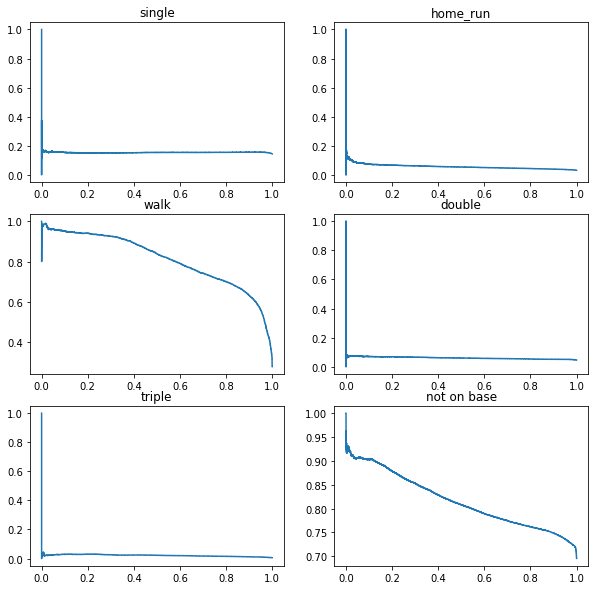

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for ax_idx, (event, idx) in enumerate(target_events.items()):
    p, r, t = precision_recall_curve(y_all[:, idx], preds[:, idx])
    ax = axs[ax_idx % 3, 0 if not ax_idx % 2 else 1]
    ax.plot(r, p)
    ax.set_title(event)

p, r, t = precision_recall_curve(y_all[:, 0], preds[:, 0])
axs[2, 1].plot(r, p)
_ = axs[2, 1].set_title('not on base')

## Defining utility functions

In [81]:
def get_feature_embeddings(X, feature, model):
    input_ = encoder.transform(X)[f'{feature}_input']
    return get_embeddings(input_, model, feature)

def get_embeddings(X, model, feature):
    input_ = model.get_layer(f'{feature}_input').get_output_at(-1)
    encoding = model.get_layer(f'{feature}_embedding').get_output_at(-1)
    return keras.models.Model(inputs=input_, outputs=encoding).predict(X)

## Look at embeddings

In [82]:
target_events

{'single': 1, 'double': 2, 'triple': 3, 'home_run': 4, 'walk': 5}

In [83]:
hybrid_model.get_layer('y').get_weights()[0][-1, 1:]

array([ 0.6217938 ,  0.7047243 , -1.8934493 ,  0.9970639 ,  0.29770803],
      dtype=float32)

In [84]:
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
batters = batters.merge(stats, left_on='batter_id', right_on='batter_mlbid')
batters = batters[batters.AB > 100]
batter_embeddings = get_feature_embeddings(batters, 'batter_id', hybrid_model).reshape(-1)
batter_coefs = hybrid_model.get_layer('y').get_weights()[0][-1, 1:].sum()
batters['prob_on_base'] = batter_embeddings * batter_coefs
batters.sort_values('prob_on_base', ascending=False).head(10)

,batter_id,batter_mlbname,batter_mlbid,H,BB,HBP,2B,3B,HR,SF,AB,1B,obp,slg,ops,prob_on_base
12,543068.0,C.J. Cron,543068.0,127,37,17.0,28,1,30,5.0,501,130,0.323214,0.616766,0.939981,1.410040
322,521692.0,Salvador Perez,521692.0,120,17,12.0,23,0,27,5.0,510,124,0.273897,0.545098,0.818995,1.378952
8,646240.0,Rafael Devers,646240.0,108,38,0.0,24,0,21,2.0,450,105,0.297959,0.526667,0.824626,1.366449
38,547989.0,Jose Abreu,547989.0,132,37,11.0,36,1,22,6.0,499,119,0.325497,0.565130,0.890628,1.334347
142,542583.0,Jesus Aguilar,542583.0,135,58,6.0,25,0,35,10.0,492,145,0.351590,0.680894,1.032484,1.312260
61,443558.0,Nelson Cruz,443558.0,133,55,14.0,18,1,37,3.0,519,153,0.341794,0.655106,0.996900,1.310524
179,592122.0,Tyler Austin,592122.0,56,19,2.0,10,0,17,3.0,244,63,0.287313,0.618852,0.906166,1.262894
99,594828.0,Evan Gattis,594828.0,92,33,3.0,17,0,25,8.0,407,100,0.283814,0.574939,0.858752,1.257863
96,608336.0,Joey Gallo,608336.0,103,74,3.0,24,1,40,0.0,500,120,0.311958,0.662000,0.973958,1.244105
363,650402.0,Gleyber Torres,650402.0,117,42,5.0,16,1,24,5.0,431,126,0.339545,0.596288,0.935832,1.241824


In [85]:
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitchers = pitchers.merge(pitching_stats, left_on='pitcher_id', right_on='pitcher_mlbid')
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', hybrid_model).reshape(-1)
pitcher_coefs = hybrid_model.get_layer('y').get_weights()[0][-2, 0]
pitchers['prob_not_on_base'] = pitcher_embeddings * pitcher_coefs
pitchers[pitchers.IP > 100].sort_values('prob_not_on_base', ascending=False).head(10)

,pitcher_id,player_name,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,prob_not_on_base
176,622072.0,Alex Wood,622072.0,151.666667,40,143,62,3.679121,1.206593,2.500644
144,592662.0,Robbie Ray,592662.0,123.666667,70,97,54,3.929919,1.350404,2.426185
181,642232.0,Ryan Yarbrough,642232.0,147.333333,50,140,64,3.909502,1.289593,2.340094
256,543243.0,Sonny Gray,543243.0,130.333333,57,138,71,4.902813,1.496164,2.314685
166,547888.0,Masahiro Tanaka,547888.0,156.000000,35,141,65,3.750000,1.128205,2.301970
373,573185.0,Dan Straily,573185.0,122.333333,52,107,56,4.119891,1.299728,2.277640
31,571578.0,Patrick Corbin,571578.0,200.000000,48,162,70,3.150000,1.050000,2.213004
399,605397.0,Joe Musgrove,605397.0,115.333333,23,113,52,4.057803,1.179191,2.180005
6,570632.0,Jose Urena,570632.0,174.000000,51,155,77,3.982759,1.183908,2.125823
315,453281.0,Wade LeBlanc,453281.0,162.000000,40,151,67,3.722222,1.179012,2.103159


In [86]:
pitchers[pitchers.IP < 100].sort_values('prob_not_on_base', ascending=False).head(10)

,pitcher_id,player_name,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,prob_not_on_base
85,547973.0,Aroldis Chapman,547973.0,51.333333,30,24,14,2.454545,1.051948,2.559563
440,657053.0,Touki Toussaint,657053.0,29.000000,21,18,13,4.034483,1.344828,2.514394
62,489334.0,Craig Stammen,489334.0,79.000000,17,65,24,2.734177,1.037975,2.507065
218,656547.0,Jonathan Holder,656547.0,66.000000,19,53,23,3.136364,1.090909,2.481973
38,493603.0,Adam Ottavino,493603.0,77.666667,36,41,21,2.433476,0.991416,2.479062
101,553878.0,Felipe Vazquez,553878.0,70.000000,24,63,21,2.700000,1.242857,2.386177
34,623184.0,Scott Oberg,623184.0,58.666667,12,46,16,2.454545,0.988636,2.357322
389,453214.0,Steven Wright,453214.0,53.666667,26,41,16,2.683230,1.248447,2.354153
378,519293.0,Will Smith,519293.0,53.000000,15,37,15,2.547170,0.981132,2.326995
103,643230.0,Steven Brault,643230.0,91.666667,57,84,47,4.614545,1.538182,2.317883


# Recurrent model

In [93]:
import keras
import keras.backend as K

# LSTM input
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh', name='W')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear', name='u_w')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention


categorical_dimmensions = {
    'batter_id': 4,
    'pitcher_id': 2,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = {}
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings[feature] = embedding

X_embeddings = keras.layers.Concatenate(axis=-1)(list(embeddings.values()))
X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.BatchNormalization()(X)
X_lstm = keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)(X)
X, attention = Attention(X_lstm)
X = keras.layers.Dense(len(target_events) + 1, activation='softmax', name='y')(X)

X_aux = keras.layers.Dense(32, activation='relu')(X_lstm)
X_aux = keras.layers.BatchNormalization()(X_aux)
X_aux = keras.layers.Dense(32, activation='relu')(X_aux)
X_aux = keras.layers.BatchNormalization()(X_aux)
X_aux = keras.layers.Dense(len(auxillary_targets), name='y_aux')(X_aux)

nonlinear_model = keras.models.Model(
    inputs=[numeric_input] + list(categorical_inputs),
    outputs=[X, X_aux])

In [94]:
nonlinear_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [95]:
nonlinear_model.compile(loss={'y': loss, 'y_aux': 'mse'}, optimizer='adam', loss_weights={'y': 1., 'y_aux': 3.})

In [96]:
L = []
def g():
    while True:
        np.random.shuffle(batches)
        for X, y, y_aux in batches:
            if len(y_aux.shape) != 3:
                L.append(None)
                continue
            yield X, {'y': y, 'y_aux': y_aux}
nonlinear_model.fit_generator(g(), steps_per_epoch=len(batches), epochs=10)

Epoch 1/10
4430/4430 [==============================] - 44s 10ms/step - loss: 2.4356 - y_loss: 1.5655 - y_aux_loss: 0.2900
Epoch 2/10
4430/4430 [==============================] - 42s 9ms/step - loss: 2.1697 - y_loss: 1.3840 - y_aux_loss: 0.2619
Epoch 3/10
4430/4430 [==============================] - 42s 10ms/step - loss: 2.0909 - y_loss: 1.3135 - y_aux_loss: 0.2592
Epoch 4/10
4430/4430 [==============================] - 42s 10ms/step - loss: 2.0460 - y_loss: 1.2711 - y_aux_loss: 0.2583
Epoch 5/10
4430/4430 [==============================] - 42s 10ms/step - loss: 2.0119 - y_loss: 1.2425 - y_aux_loss: 0.2565
Epoch 6/10
4430/4430 [==============================] - 42s 9ms/step - loss: 1.9818 - y_loss: 1.2139 - y_aux_loss: 0.2560
Epoch 7/10
4430/4430 [==============================] - 42s 10ms/step - loss: 1.9691 - y_loss: 1.2017 - y_aux_loss: 0.2558
Epoch 8/10
4430/4430 [==============================] - 42s 9ms/step - loss: 1.9531 - y_loss: 1.1871 - y_aux_loss: 0.2553
Epoch 9/10
4430/443

In [97]:
len(L)

141

## P/R curves

In [98]:
preds = np.concatenate([nonlinear_model.predict(x)[0] for x, _, _ in batches])
y_all = np.concatenate([y for _, y, _ in batches])

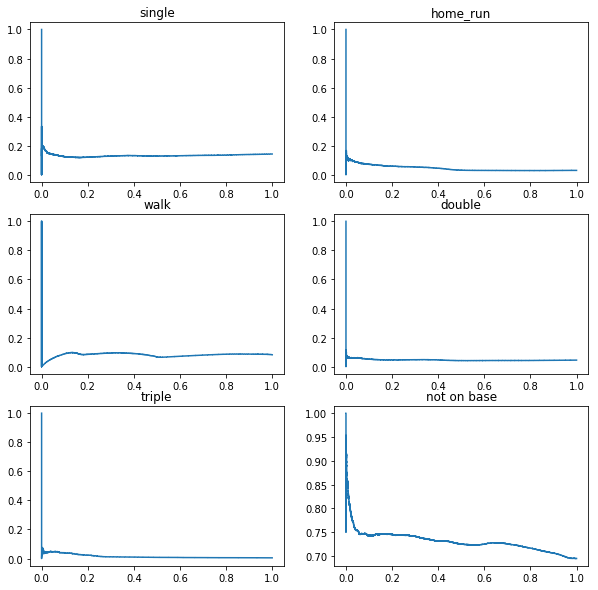

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for ax_idx, (event, idx) in enumerate(target_events.items()):
    p, r, t = precision_recall_curve(y_all[:, idx], preds[:, idx])
    axs[ax_idx % 3, 0 if not ax_idx % 2 else 1].plot(r, p)
    axs[ax_idx % 3, 0 if not ax_idx % 2 else 1].set_title(event)

p, r, t = precision_recall_curve(y_all[:, 0], preds[:, 0])
axs[2, 1].plot(r, p)
_ = axs[2, 1].set_title('not on base')

# Inspect model

## Pitcher embeddings

In [100]:
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitchers = pitching_stats.merge(pitchers, left_on='pitcher_mlbid', right_on='pitcher_id')
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', nonlinear_model)
pitchers['x'], pitchers['y'] = zip(*pitcher_embeddings.reshape((-1, 2)))

In [101]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

lookat =  'WHIP'

source = ColumnDataSource(
        data=dict(
            x=pitchers.x,
            y=pitchers.y,
            desc=pitchers.player_name,
            WHIP=pitchers.WHIP
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256[::-1], low=pitchers[lookat].min(), high=pitchers[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)

Loading BokehJS ...

## Look at batter embeddings

In [102]:
from sklearn.manifold import TSNE
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
batters = batters.merge(stats, left_on='batter_id', right_on='batter_mlbid')
batters = batters[batters.AB > 100]
batter_embeddings = get_feature_embeddings(batters, 'batter_id', nonlinear_model)
batters['x'], batters['y'] = zip(*TSNE(2).fit_transform(batter_embeddings.reshape((-1, 4))))

In [103]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()

lookat = {
    'Mike Trout': 'red',
    'Christian Yelich': 'green',
    'Bryce Harper': 'orange',
    'Mookie Betts': 'pink',
    'Rhys Hoskins': 'purple',
    'Jean Segura': 'grey'
}

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)


Loading BokehJS ...

In [104]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'slg'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            slg=batters.slg,
            obp=batters.obp,
            ops=batters.ops,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

In [105]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'ops'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            slg=batters.slg,
            obp=batters.obp,
            ops=batters.ops,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

## Look at attention

In [ ]:
A = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=attention)

In [ ]:
batch_idx = 3
bx, by, _ = batches[batch_idx]
aa = np.squeeze(A.predict(bx))
bx['numeric_inputs'].shape, aa.shape

In [ ]:
aa

In [ ]:
np.argmax(aa, axis=1)

In [ ]:
p = nonlinear_model.predict(bx)
p[0].shape

In [ ]:
inverse_target_map = {v: k for k, v in target_events.items()}
def inverse_transform(X):
    d = pd.DataFrame(X['numeric_inputs'], columns=numeric_features)
    for f in categorical_features:
        d[f] = encoder.inverse_transform(pd.Series(X[f'{f}_input']), f)
    return d

In [ ]:
bx

In [ ]:
idx = 0

In [ ]:
idx += 1
d = inverse_transform({k: v[idx] for k, v in bx.items()})
d['attention'] = aa[idx].reshape(-1)
d = d.merge(batters[['batter_id', 'batter_mlbname']])
d = d.merge(pitchers[['pitcher_id', 'player_name']])

print('was', inverse_target_map.get(np.argmax(by[idx]), 'not on base event'))
print('predicted', inverse_target_map.get(np.argmax(p[0][idx]), 'not on base event'))

with pd.option_context('display.max_columns', None):
    display(d)

# counterfactuals

In [ ]:
nonlinear_model.inputs

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import log_loss

def make_loss(model, y_new, x_old, lambda_):
    x_base = {k: v for k, v in x_old.items()}
    x_shape = x_base['numeric_inputs'].shape
    def loss(x):
        x = x.reshape(x_shape)
        x_base['numeric_inputs'] = x
        y_hat = model.predict(x_base).reshape(-1)
        L = lambda_ * log_loss(y_new, y_hat)
        d = np.sum((x - x_old['numeric_inputs']) ** 2)
        return L + d
    return loss

In [ ]:
batch_idx = 0
idx = 0
bx, by, _ = batches[batch_idx]
x_old = {k: np.expand_dims(v[idx], 0) for k, v in bx.items()}
loss = make_loss(
    model,
    np.array([0, 0, 0, 0, 0, 1]),
    x_old,
    2)
minimize(loss, x_old['numeric_inputs'], method='Nelder-Mead')